In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import seaborn as sns
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility

# Common modules

In [156]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image_continuous(pred_batch, truth_batch, grid_len, debug=False):
        '''Continuous -- for single TX
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are continuous numbers
        Args:
            pred_batch:  tensor -- size=(N, 1, 100, 100)
            truth_batch: tensor -- size=(N, num_tx, 2)
        '''
        error = []
        for idx, pred, truth in zip(range(len(pred_batch)), pred_batch, truth_batch):
            # 1: get the multiple predicted locations
            pred = pred[0]           # there is only one channel
            pred_floats = []         # get the predictions 
            for _ in range(len(truth)):
                indx = np.argmax(pred)
                pred_x = indx // grid_len
                pred_y = indx %  grid_len
                neighbor = []
                sum_weight = 0
                for d in [(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]:
                    nxt = (pred_x + d[0], pred_y + d[1])
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        neighbor.append(((nxt[0] + 0.5, nxt[1] + 0.5), pred[nxt[0]][nxt[1]]))
                        sum_weight += pred[nxt[0]][nxt[1]]
                pred_x, pred_y = 0, 0
                for n in neighbor:
                    loc = n[0]
                    w   = n[1]
                    pred_x += loc[0]/sum_weight*w
                    pred_y += loc[1]/sum_weight*w
                pred_floats.append((pred_x, pred_y))
                # need to remove the peaks from the images, let's say an area of 3 by 3
                for i in [-2, -1, 0, 1, 2]:
                    for j in [-2, -1, 0, 1, 2]:
                        nxt = (int(pred_x + i), int(pred_y + j))
                        if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                            pred[nxt[0]][nxt[1]] = 0

            # 2: do a matching and get the error
            pred_floats, truth = Match.match(pred_floats, truth)
            err_one_sample = []
            for pred_float, y in zip(pred_floats, truth):
                dist = Utility.distance(pred_float, y)
                if debug:
                    print(idx, pred_float, y, dist)
                err_one_sample.append(dist)
            error.append(np.mean(err_one_sample))
        return error


class Match:
    @staticmethod
    def match(pred, y):
        ''' up to now, assume len(pred) and len(y) is equal
            do a matching of the predictions and truth
        Args:
            pred: list<list<float>> -- pairs of locations
            y   : list<np.ndarray<float>> -- pairs of locations
        Return:
            list<list<float>>, list<list<float>>  -- same dimension as arguments, just reordering
        '''
        distances = np.zeros((len(pred), len(y)))
        for i in range(len(pred)):
            for j in range(len(y)):
                distances[i, j] = Utility.distance(pred[i], y[j])

        matches = []
        k = 0
        while k < min(len(pred), len(y)):
            min_error = np.min(distances)
            min_error_index = np.argmin(distances)
            i = min_error_index // len(y)
            j = min_error_index % len(y)
            matches.append((i, j, min_error))
            distances[i, :] = np.inf
            distances[:, j] = np.inf
            k += 1

        pred_m, y_m = [], []
        for i, j, e in matches:
            pred_m.append(pred[i])
            y_m.append(y[j])

        return pred_m, y_m
    
    @staticmethod
    def detect_peaks(pred_image):
        """
        Takes an image and detect the peaks usingthe local maximum filter.
        Returns a boolean mask of the peaks (i.e. 1 when
        the pixel's value is the neighborhood maximum, 0 otherwise)
        """
        # define an 8-connected neighborhood
        neighborhood = generate_binary_structure(2,2)

        #apply the local maximum filter; all pixel of maximal value 
        #in their neighborhood are set to 1
        local_max = maximum_filter(pred_image, footprint=neighborhood)==pred_image
        #local_max is a mask that contains the peaks we are 
        #looking for, but also the background.
        #In order to isolate the peaks we must remove the background from the mask.

        #we create the mask of the background
        background = (pred_image < 0.01)

        #a little technicality: we must erode the background in order to 
        #successfully subtract it form local_max, otherwise a line will 
        #appear along the background border (artifact of the local maximum filter)
        eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

        #we obtain the final mask, containing only peaks, 
        #by removing the background from the local_max mask (xor operation)
        detected_peaks = local_max ^ eroded_background
        return detected_peaks

# 2 Output is image, model as image translation problem

## Output representation is a grid (image)
## Use weighting to get a continuous output prediction

## Data

In [3]:
class SensorInputDatasetTranslation(Dataset):
    '''Sensor reading input dataset -- for multi TX
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        target_img, target_float = self.get_translation_target(folder, target_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        sample = {'matrix':matrix, 'target':target_img, 'target_float':target_float}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_translation_target(self, folder: str, target_name: str):
        '''
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixel with the TX is labeled 1, everywhere else is labeled 0
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            neighbor = []
            sum_weight = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                        sum_weight += weight
                        neighbor.append((nxt, weight))
            for n, w in neighbor:
                grid[n[0]][n[1]] = w / sum_weight * len(neighbor)
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)


tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

# training
i = 0
root_dir = './data/matrix-train30'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_dataset[i]['matrix'].shape)
print(sensor_input_dataset[i]['target'])
print(sensor_input_dataset[i]['target_float'])
print(sensor_input_dataset.__len__())

# testing
root_dir = './data/matrix-test30'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_test_dataset[i]['matrix'].shape)
print(sensor_input_test_dataset[i]['target'])
print(sensor_input_test_dataset[i]['target_float'])
print(sensor_input_test_dataset.__len__())

torch.Size([1, 100, 100])
[[[2.2074277  0.53392583 0.         ... 0.         0.         0.        ]
  [0.8044668  0.45417964 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
[[ 0.7523271  0.3895659]
 [48.994858  64.993996 ]]
100000
torch.Size([1, 100, 100])
[[[1.4273249  1.3868178  0.         ... 0.         0.         0.        ]
  [0.59444475 0.59141254 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         

In [4]:
print(sensor_input_dataset[0]['target_float'])
print(sensor_input_dataset[0]['target'][0][46:51, 62:67])

[[ 0.7523271  0.3895659]
 [48.994858  64.993996 ]]
[[0.        0.        0.        0.        0.       ]
 [0.        0.4912577 0.6594669 0.6578752 0.       ]
 [0.        0.6596964 1.4848477 1.4669416 0.       ]
 [0.        0.6583311 1.4694728 1.4521108 0.       ]
 [0.        0.        0.        0.        0.       ]]


## Model

In [5]:
# model

class NetTranslation(nn.Module):
    '''The output dimension of the full connnection layer is 100 x 100 = 10000
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv2d(8, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 1, 5, padding=2)
        self.groupnorm1 = nn.GroupNorm(1, 8)
        self.groupnorm2 = nn.GroupNorm(1, 32)
        
    def forward(self, x):
#         x = F.relu(self.groupnorm1(self.conv1(x)))
#         x = F.relu(self.groupnorm2(self.conv2(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

net2 = NetTranslation()
print(net2)

NetTranslation(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (groupnorm1): GroupNorm(1, 8, eps=1e-05, affine=True)
  (groupnorm2): GroupNorm(1, 32, eps=1e-05, affine=True)
)


## Loss is nn.MSELoss()

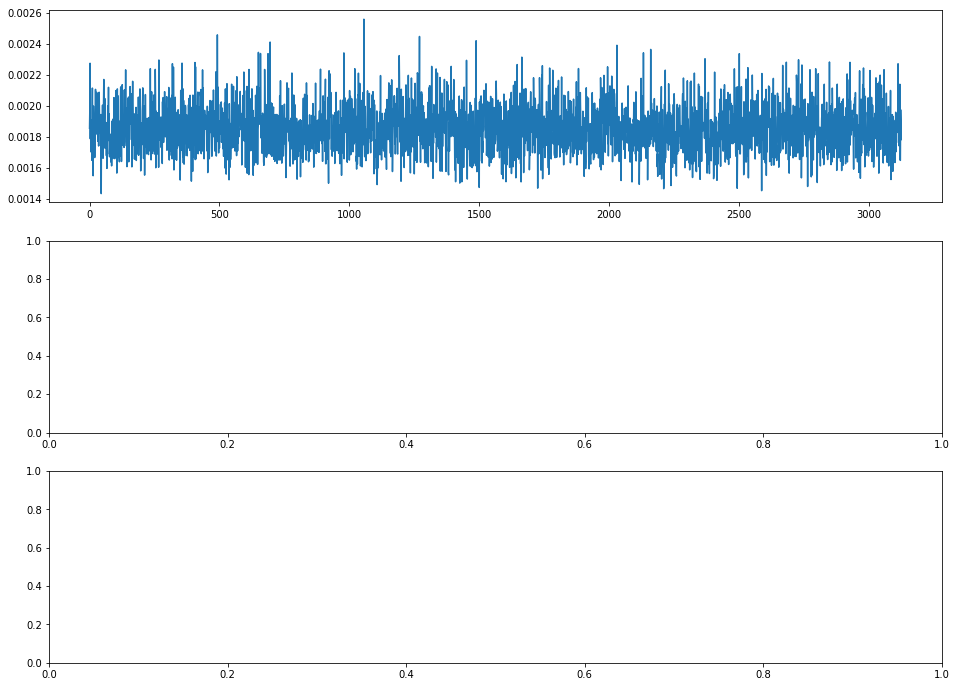

train loss mean = 0.0018529166701436043
train loss std  = 0.00015439597107473233
train mean = nan
train std  = nan
test mean = nan
test std  = nan
train loss
(0.0021946046842634677, 0.00022767213120949544)
(0.0019571831572428346, 0.0001573303528800691)
(0.0019158883956819773, 0.00015807737819721612)
(0.0019365717655420304, 0.00015478125665245755)
(0.0019071083741635084, 0.00015651037847559695)
(0.0018705222576484084, 0.00015885536392210438)
(0.0018540407720580698, 0.00015444758228664438)
(0.0018454696620628238, 0.0001530638706734979)
(0.0018678783988207578, 0.00015986320082126798)
(0.0018529166701436043, 0.00015439597107473233)


In [95]:
# %%time
# image translation problem

net2 = NetTranslation()

device    = torch.device('cuda')
model     = net2.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # criterion is the loss function

num_epochs = 10
train_losses_epoch = []
train_errors_epoch = []
test_errors_epoch  = []
print_every = 500
error_every = 20

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_errors  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_float = sample['target_float']
        pred = model(X)
        loss = criterion(pred, y) + criterion2(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred = pred.data.cpu()
#         if t % error_every == 0:
#             train_errors.extend(Metrics.localization_error_image_continuous(pred, y_float, Default.grid_length))
        if t % print_every == 0:
            print(f't = {t}, loss = {loss.item()}')

#     break
    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_float = sample['target_float']
        pred = model(X)
        pred = pred.data.cpu()
#         if t % error_every == 0:
#             test_errors.extend(Metrics.localization_error_image_continuous(pred, y_float, Default.grid_length))
    
    clear_output(True)
    plt.figure(figsize=(16, 12))
    plt.subplot(311)
    plt.plot(train_losses)
    plt.subplot(312)
#     plt.plot(train_errors)
    plt.subplot(313)
#     plt.plot(test_errors)
    plt.show()
    
    print('train loss mean =', np.mean(train_losses))
    print('train loss std  =', np.std(train_losses))
    print('train mean =', np.mean(train_errors))
    print('train std  =', np.std(train_errors))    
    print('test mean =', np.mean(test_errors))
    print('test std  =', np.std(test_errors))
    train_losses_epoch.append((np.mean(train_losses), np.std(train_losses)))
#     train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
#     test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))

print('train loss')
for loss in train_losses_epoch:
    print(loss)
# print('train error')
# for error in train_errors_epoch:
#     print(error)
# print('test error')
# for error in test_errors_epoch:
#     print(error)

In [210]:
def myplot(X, pred, y):
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    sns.heatmap(X[0], cmap='gray', annot=False, ax=axs[0])
    sns.heatmap(pred[0], cmap='gray', annot=False, ax=axs[1])
    sns.heatmap(y[0], cmap='gray', annot=False, ax=axs[2])
    fig.tight_layout()

def myplot2(pred, y, y_float):
    print(y_float)
    fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'pred {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(pred[0][a1:a2,b1:b2], cmap='gray', annot=True, ax=axs[i])
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'y    {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(y[0][a1:a2, b1:b2], cmap='gray', annot=True, ax=axs[i+2])
    fig.tight_layout()

In [143]:
model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_f = sample['target_float']
    pred = model(X)
    errors = Metrics.localization_error_image_continuous(pred.data.cpu(), y_f, Default.grid_length, True)
    print(np.mean(errors), np.std(errors))
    break

X    = X.data.cpu().numpy()
pred = pred.data.cpu().numpy()
y    = y.data.cpu().numpy()

0 (tensor(85.5868), tensor(63.4698)) tensor([86.2308, 63.3219]) 0.660799875202121
0 (tensor(82.6261), tensor(1.4812)) tensor([83.0573,  0.8069]) 0.800385465740296
1 (tensor(69.6232), tensor(91.5290)) tensor([69.5847, 91.6501]) 0.1271037455357293
1 (tensor(33.5776), tensor(28.4045)) tensor([33.7563, 27.6891]) 0.737398255328915
2 (tensor(76.5899), tensor(56.4631)) tensor([75.9831, 55.8973]) 0.8296598210719691
2 (tensor(98.3898), tensor(74.5142)) tensor([99.6666, 74.4393]) 1.2790292241483718
3 (tensor(75.4974), tensor(2.4779)) tensor([75.8240,  2.2926]) 0.37544682823316694
3 (tensor(71.7616), tensor(0.6133)) tensor([25.0011, 65.1568]) 79.70199010415298
4 (tensor(92.3444), tensor(58.6736)) tensor([92.4930, 59.0700]) 0.4233329974790177
4 (tensor(65.7257), tensor(99.3151)) tensor([64.1949, 97.4577]) 2.4069682448875334
5 (tensor(82.6346), tensor(60.4417)) tensor([84.3139, 59.5045]) 1.9231749069487376
5 (tensor(85.6920), tensor(61.5333)) tensor([77.8619, 77.5125]) 17.79448787765821
6 (tensor(6

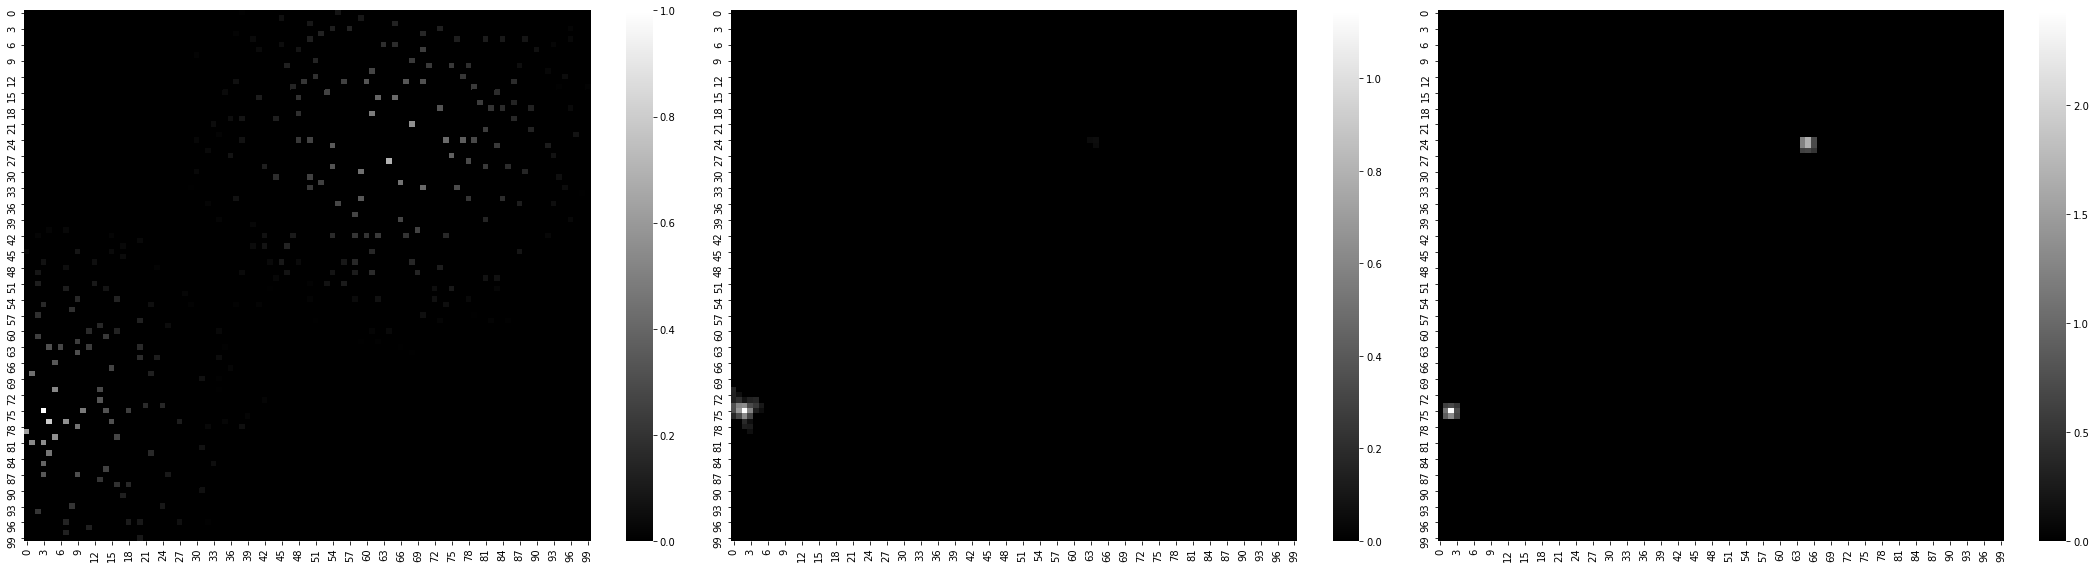

In [208]:
i = 3
myplot(X[i], pred[i], y[i])

tensor([[75.8240,  2.2926],
        [25.0011, 65.1568]])
pred 0 (70, 80), (0, 7)
pred 1 (20, 30), (60, 70)
y    0 (70, 80), (0, 7)
y    1 (20, 30), (60, 70)


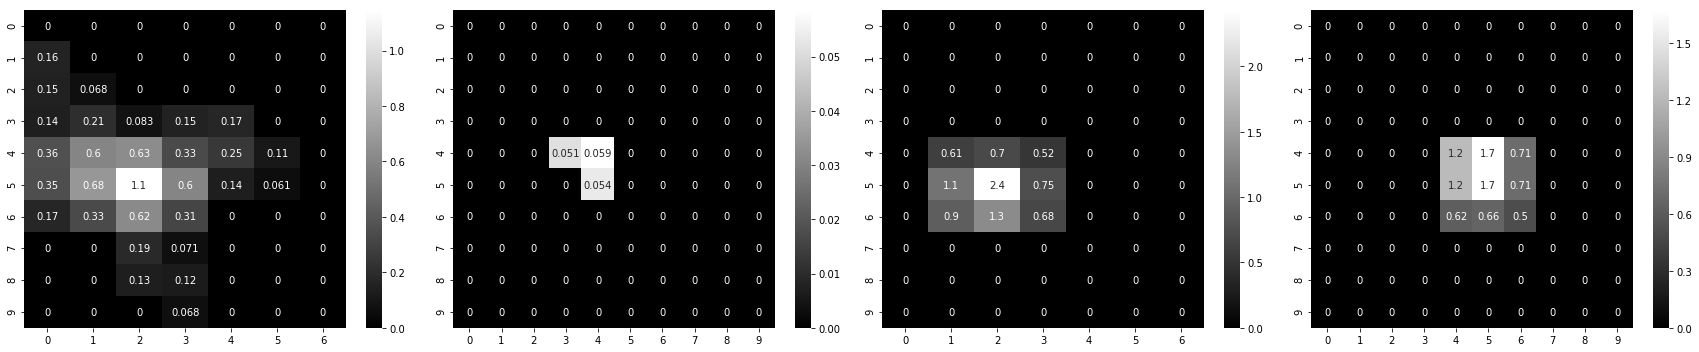

In [211]:
myplot2(pred[i], y[i], y_f[i])

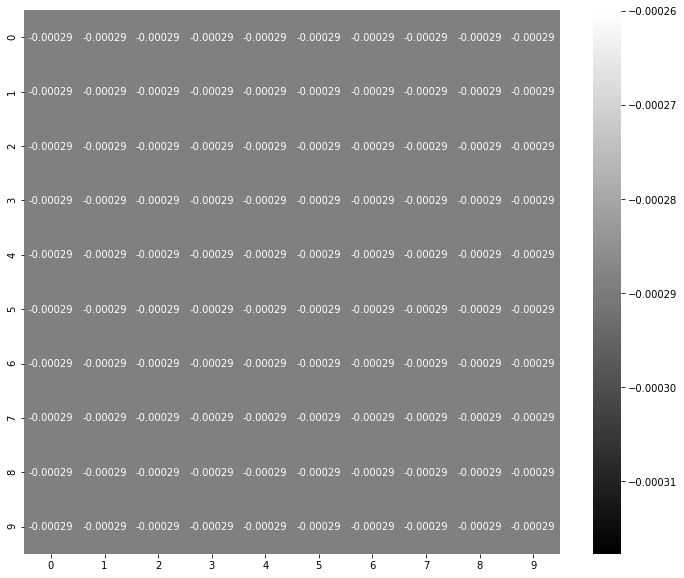

In [144]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred[i, 0][:10,:10], cmap='gray', annot=True)

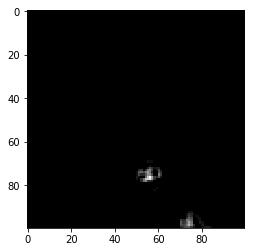

In [206]:
plt.imshow(pred[i, 0], cmap='gray')

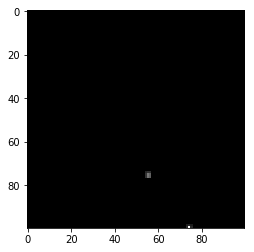

In [207]:
plt.imshow(y[i, 0], cmap='gray')

# Mics

In [173]:
neighborhood

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [175]:
np.array([[True for _ in range(4)] for _ in range((4))])

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

<class 'numpy.ndarray'> (100, 100) <class 'numpy.ndarray'> (100, 100)


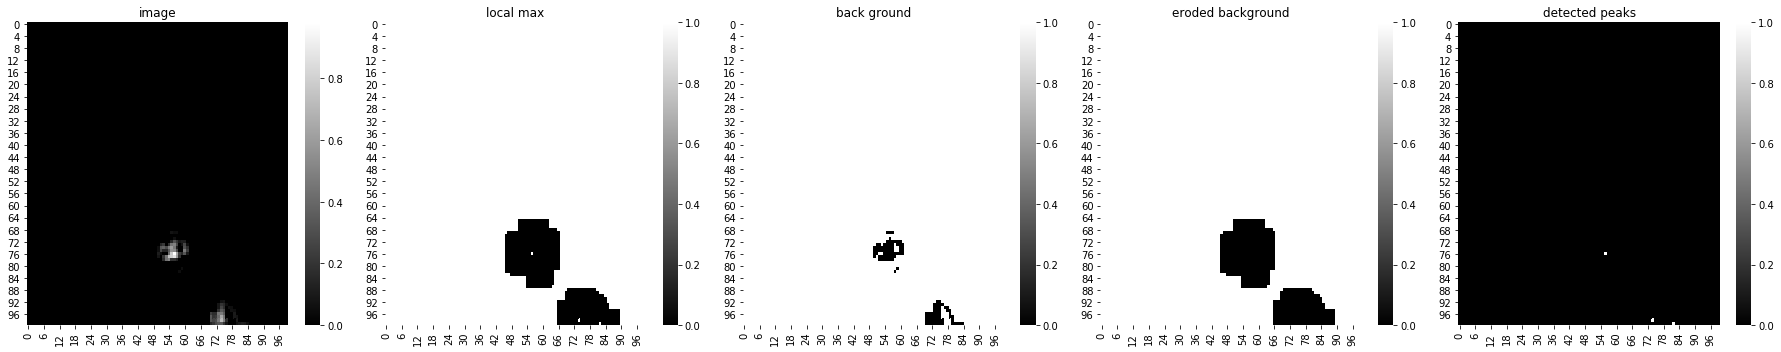

In [205]:
i = 2
image = pred[i][0]
threshold = 0.05
size = 10

threshold_mask = image < threshold
image[threshold_mask] = 0

neighborhood = np.array([[True for _ in range(size)] for _ in range((size))])

#apply the local maximum filter; all pixel of maximal value 
#in their neighborhood are set to 1
local_max = maximum_filter(image, footprint=neighborhood)==image
#local_max is a mask that contains the peaks we are 
#looking for, but also the background.
#In order to isolate the peaks we must remove the background from the mask.
#we create the mask of the background
background = (image < 0.05)
#a little technicality: we must erode the background in order to 
#successfully subtract it form local_max, otherwise a line will 
#appear along the background border (artifact of the local maximum filter)
eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
#we obtain the final mask, containing only peaks, 
#by removing the background from the local_max mask (xor operation)
print(type(local_max), local_max.shape, type(eroded_background), eroded_background.shape)
detected_peaks = local_max ^ eroded_background

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
sns.heatmap(image, cmap='gray', annot=False, ax = axes[0])
sns.heatmap(local_max, cmap='gray', annot=False, ax = axes[1])
sns.heatmap(background, cmap='gray', annot=False, ax = axes[2])
sns.heatmap(eroded_background, cmap='gray', annot=False, ax = axes[3])
sns.heatmap(detected_peaks, cmap='gray', annot=False, ax = axes[4])
axes[0].set_title('image')
axes[1].set_title('local max')
axes[2].set_title('back ground')
axes[3].set_title('eroded background')
axes[4].set_title('detected peaks')
fig.tight_layout()

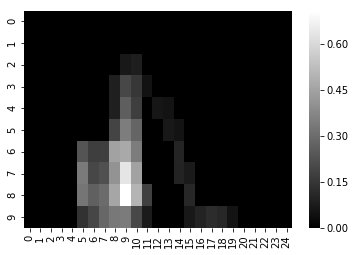

In [197]:
sns.heatmap(image[90:100, 65:90], cmap='gray')